In [203]:
import scipy.io
import pandas as pd
import numpy as np
import datetime

In [204]:
b0005 = scipy.io.loadmat("./dataset/B0005.mat")
b0006 = scipy.io.loadmat("./dataset/B0006.mat")
b0018 = scipy.io.loadmat("./dataset/B0018.mat")

In [205]:
print(b0005.keys())
print(b0006.keys())
print(b0018.keys())

dict_keys(['__header__', '__version__', '__globals__', 'B0005'])
dict_keys(['__header__', '__version__', '__globals__', 'B0006'])
dict_keys(['__header__', '__version__', '__globals__', 'B0018'])


In [206]:
cycles_5 = b0018['B0018']['cycle'][0,0][0]
discharge_cycles = []
for idx, c in enumerate(cycles_5, start=1):
    ctype = c['type'][0]
    if ctype == 'discharge':
        discharge_cycles.append((idx, c))
print("Toplam discharge cycle sayısı:", len(discharge_cycles))


Toplam discharge cycle sayısı: 132


In [207]:
first_cap = discharge_cycles[0][1]['data'][0,0]['Capacity'][0,0]

ts_cycles = {}
ts_rows = []

for idx, c in discharge_cycles:
    t = c['time'][0]
    start_dt = datetime.datetime(int(t[0]), int(t[1]), int(t[2]),
                                 int(t[3]), int(t[4]), int(t[5]))
    d = c['data'][0,0]

    cap = float(d['Capacity'][0,0])
    V   = d['Voltage_measured'][0].astype(float)
    I   = d['Current_measured'][0].astype(float)
    T   = d['Temperature_measured'][0].astype(float)
    tm  = d['Time'][0].astype(float)

    I_load = d['Current_load'][0].astype(float) if 'Current_load' in d.dtype.names else np.full_like(V, np.nan)
    V_load = d['Voltage_load'][0].astype(float) if 'Voltage_load' in d.dtype.names else np.full_like(V, np.nan)

    # ---- cycle-bazlı SOC (tek değer)
    soc_cycle = cap / first_cap

    dt_arr = np.diff(tm, prepend=tm[0])
    sign = -1.0 if np.nanmedian(I) < 0 else 1.0
    q_drawn_ah = np.cumsum(sign * I * dt_arr) / 3600.0  # Ah

    soc_whole_t   = np.clip(soc_cycle - q_drawn_ah / first_cap, 0, 1.05)
    soc_cyclecap_t  = np.clip(1 - q_drawn_ah / cap,       0, 1.05)

    ts_rows.append({
        "cycle_id": idx,
        "datetime": start_dt,
        "time_s": tm,
        "voltage_V": V,
        "current_A": I,
        "temperature_C": T,
        "current_load_A": I_load,
        "voltage_load_V": V_load,
        "soc_whole_t": soc_whole_t,
        "soc_cyclecap_t": soc_cyclecap_t,
        "capacity_Ah": cap,
        "soc_cycle": cap / first_cap
    })

# 3) Long-form zaman serisi tablo (tüm discharge cycle'lar bir arada)
df_timeseries = pd.DataFrame(ts_rows).sort_values("datetime").reset_index(drop=True)

df_timeseries.tail(10)

,cycle_id,datetime,time_s,voltage_V,current_A,temperature_C,current_load_A,voltage_load_V,soc_whole_t,soc_cyclecap_t,capacity_Ah,soc_cycle
122,298,2008-08-18 21:48:48,"[0.0, 9.453, 23.703000000000003, 37.203, 50.71...","[4.186834478731371, 4.186680782310775, 3.97380...","[-0.002705787794314147, 0.002535150674126186, ...","[23.11781710619391, 23.11186259982214, 23.1279...","[0.0006, 0.0006, 1.9986, 1.9986, 1.9984, 1.998...","[0.0, 4.202, 3.001, 2.994, 2.975, 2.959, 2.95,...","[0.7512061203027418, 0.7512097089102469, 0.746...","[1.0, 1.0000047771276193, 0.9943040170488237, ...",1.393491,0.751206
123,300,2008-08-19 01:25:43,"[0.0, 9.469, 23.703000000000003, 37.203, 50.75...","[4.185890317458504, 4.186613091061155, 3.97271...","[-0.0016087041499312819, -0.000410880722706816...","[23.04417103672731, 23.04429815552573, 23.0669...","[0.0006, 0.0006, 1.9986, 1.9986, 1.9986, 1.998...","[0.0, 4.201, 2.998, 2.996, 2.976, 2.961, 2.949...","[0.7483805757157408, 0.748379993113153, 0.7440...","[1.0, 0.9999992215156209, 0.9942782865589324, ...",1.388249,0.748381
124,302,2008-08-19 05:17:05,"[0.0, 9.405999999999999, 23.811999999999998, 3...","[4.183775890805592, 4.183907160253637, 3.96785...","[-0.00222726472418298, 0.0023323566495707213, ...","[22.83426471365, 22.83956328032187, 22.8666663...","[0.0004, 0.0004, 1.9986, 1.9986, 1.9984, 1.998...","[0.0, 4.199, 3.011, 2.995, 2.974, 2.957, 2.943...","[0.7386439323920165, 0.7386472175212739, 0.734...","[1.0, 1.0000044475140366, 0.9941422556397537, ...",1.370188,0.738644
125,305,2008-08-19 09:39:42,"[0.0, 9.36, 23.703, 37.25, 50.797, 64.36, 77.9...","[4.184700856653747, 4.18533882899107, 3.970085...","[-0.001604265359648308, 0.0013953395427067014,...","[22.849334336507724, 22.83589303178486, 22.864...","[0.0006, 0.0006, 1.9986, 1.9986, 1.9986, 1.998...","[0.0, 4.201, 2.98, 2.987, 2.967, 2.95, 2.939, ...","[0.743769166650052, 0.7437711223772593, 0.7394...","[1.0, 1.000002629481424, 0.9942052645690515, 0...",1.379695,0.743769
126,307,2008-08-19 13:17:33,"[0.0, 9.359, 23.719, 37.266, 50.875, 64.469, 7...","[4.184705779748733, 4.185280284017658, 3.97019...","[-0.0017142363283387748, 0.0015827784709912481...","[23.179921311075763, 23.180800875919797, 23.20...","[0.0006, 0.0006, 1.9986, 1.9986, 1.9986, 1.998...","[0.0, 4.2, 2.99, 2.99, 2.971, 2.955, 2.943, 2....","[0.7378195670433692, 0.7378217852505583, 0.733...","[1.0, 1.0000030064358392, 0.9941452483503904, ...",1.368659,0.737820
127,309,2008-08-19 16:54:51,"[0.0, 9.311999999999998, 23.671999999999997, 3...","[4.186190318516221, 4.186281579801858, 3.97151...","[-0.0014430209942525906, -0.002614624133615274...","[23.71915866436032, 23.715085051859607, 23.746...","[0.0006, 0.0006, 1.9988, 1.9988, 1.9986, 1.998...","[0.0, 4.201, 3.001, 2.994, 2.977, 2.965, 2.955...","[0.7346274160714679, 0.7346237701714086, 0.730...","[1.0, 0.999995037075966, 0.9941159493078975, 0...",1.362737,0.734627
128,311,2008-08-19 20:32:20,"[0.0, 9.328000000000003, 23.813000000000002, 3...","[4.184617620212458, 4.185356132672309, 3.97140...","[-0.0036696451123494705, 0.000870561285181927,...","[24.04968560418804, 24.038521624132176, 24.062...","[0.0006, 0.0006, 1.9986, 1.9986, 1.9986, 1.998...","[0.0, 4.201, 2.988, 2.989, 2.969, 2.955, 2.945...","[0.7349874882306875, 0.7349887042498365, 0.730...","[1.0, 1.0000016544759858, 0.9940719122365667, ...",1.363405,0.734987
129,314,2008-08-20 00:43:05,"[0.0, 9.311999999999998, 23.765, 37.406, 51.09...","[4.181406543107895, 4.181340800349946, 3.96498...","[-0.0034325036976201825, 0.004238943215349039,...","[23.56288829160871, 23.564326644644353, 23.589...","[0.0006, 0.0006, 1.9986, 1.9986, 1.9986, 1.998...","[0.0, 4.197, 3.013, 2.998, 2.975, 2.957, 2.946...","[0.7287662042753458, 0.7287721151682811, 0.724...","[1.0, 1.0000081108219627, 0.9940447466769098, ...",1.351865,0.728766
130,317,2008-08-20 05:02:00,"[0.0, 9.359000000000002, 23.844, 37.562, 51.31...","[4.18481632859354, 4.185252405343103, 3.968846...","[-0.0031652062829820213, -0.0014

In [208]:
df_sorted = df_timeseries.sort_values("datetime").reset_index(drop=True)

# 2) Bir sonraki satırla karşılaştır: cycle_id azalmış mı?
mask_adj = df_sorted["cycle_id"] > df_sorted["cycle_id"].shift(-1)

# 3) Sorunlu komşu çiftleri raporla
problems_adj = df_sorted[mask_adj].copy()
report_adj = pd.DataFrame({
    "row_idx": problems_adj.index,
    "dt_current": problems_adj["datetime"],
    "cycle_current": problems_adj["cycle_id"],
    "dt_next": df_sorted["datetime"].shift(-1)[mask_adj],
    "cycle_next": df_sorted["cycle_id"].shift(-1)[mask_adj]
}).reset_index(drop=True)

report_adj


,row_idx,dt_current,cycle_current,dt_next,cycle_next


Cycle_id ile datetime uyumlu yani id sırası zamansal sıra olarak düşünülebilir

In [283]:
rows_summary = []

for _, row in df_timeseries.iterrows():
    V   = row["voltage_V"]
    I   = row["current_A"]
    T   = row["temperature_C"]
    V_load = row["voltage_load_V"]
    I_load = row["current_load_A"]
    tm  = row["time_s"]

    # cycle özet değerler
    summary = {
        "cycle_id": row["cycle_id"],
        "datetime": row["datetime"],
        "capacity_Ah": row["capacity_Ah"],
        "soc_cycle": row["soc_cycle"],   # capacity / first_cap

        # Voltage
        "voltage_mean": np.nanmean(V),
        "voltage_min": np.nanmin(V),
        "voltage_max": np.nanmax(V),

        # Current
        "current_mean": -np.nanmean(I),
        "current_min": np.nanmin(I),
        "current_max": np.nanmax(I),

        # Temperature
        "temp_mean": -np.nanmean(T),
        "temp_max": np.nanmax(T),

        # Duration
        "duration_s": float(tm[-1] - tm[0]),

        # Load tarafı
        "voltage_load_mean": np.nanmean(V_load),
        "current_load_mean": np.nanmean(I_load),
    }
    rows_summary.append(summary)

df_summary = pd.DataFrame(rows_summary).sort_values("datetime").reset_index(drop=True)
df_summary.tail(10)


,cycle_id,datetime,capacity_Ah,soc_cycle,voltage_mean,voltage_min,voltage_max,current_mean,current_min,current_max,temp_mean,temp_max,duration_s,voltage_load_mean,current_load_mean
122,298,2008-08-18 21:48:48,1.393491,0.751206,3.459667,2.344037,4.186834,1.797010,-2.012421,0.003329,-31.111641,38.083072,2817.375,2.309641,1.788269
123,300,2008-08-19 01:25:43,1.388249,0.748381,3.462242,2.456437,4.186613,1.786151,-2.013158,0.003253,-31.037910,37.882796,2809.234,2.296192,1.777658
124,302,2008-08-19 05:17:05,1.370188,0.738644,3.455566,2.395548,4.183907,1.784162,-2.012317,0.004024,-30.967951,37.960271,2791.187,2.282248,1.775506
125,305,2008-08-19 09:39:42,1.379695,0.743769,3.458696,2.453675,4.185339,1.784526,-2.015225,0.003032,-30.939962,37.880513,2794.016,2.287898,1.775551
126,307,2008-08-19 13:17:33,1.368659,0.737820,3.452528,2.306273,4.185280,1.792067,-2.014214,0.011630,-31.295019,38.434163,2774.719,2.290995,1.783263
127,309,2008-08-19 16:54:51,1.362737,0.734627,3.455229,2.347109,4.186282,1.782780,-2.012842,0.001790,-31.818465,38.847490,2777.844,2.285750,1.773505
128,311,2008-08-19 20:32:20,1.363405,0.734987,3.461974,2.488429,4.185356,1.772521,-2.014393,0.004783,-32.000672,38.802834,2781.125,2.276868,1.763543
129,314,2008-08-20 00:43:05,1.351865,0.728766,3.452222,2.399218,4.181407,1.769870,-2.012836,0.004239,-31.739922,38.726991,2760.906,2.262391,1.761211
130,317,2008-08-20 05:02:00,1.354797,0.730347,3.447650,2.278634,4.185252,1.788485,-2.011864,0.003420,-31.526136,38.671920,2753.250,2.286657,1.779889
131,319,2008-08-20 08:37:19,1.341051,0.722937,3.447929,2.365585,4.185763,1.777740,-2.012869,0.003082,-31.276245,38.371814,2742.843,2.269965,1.768835


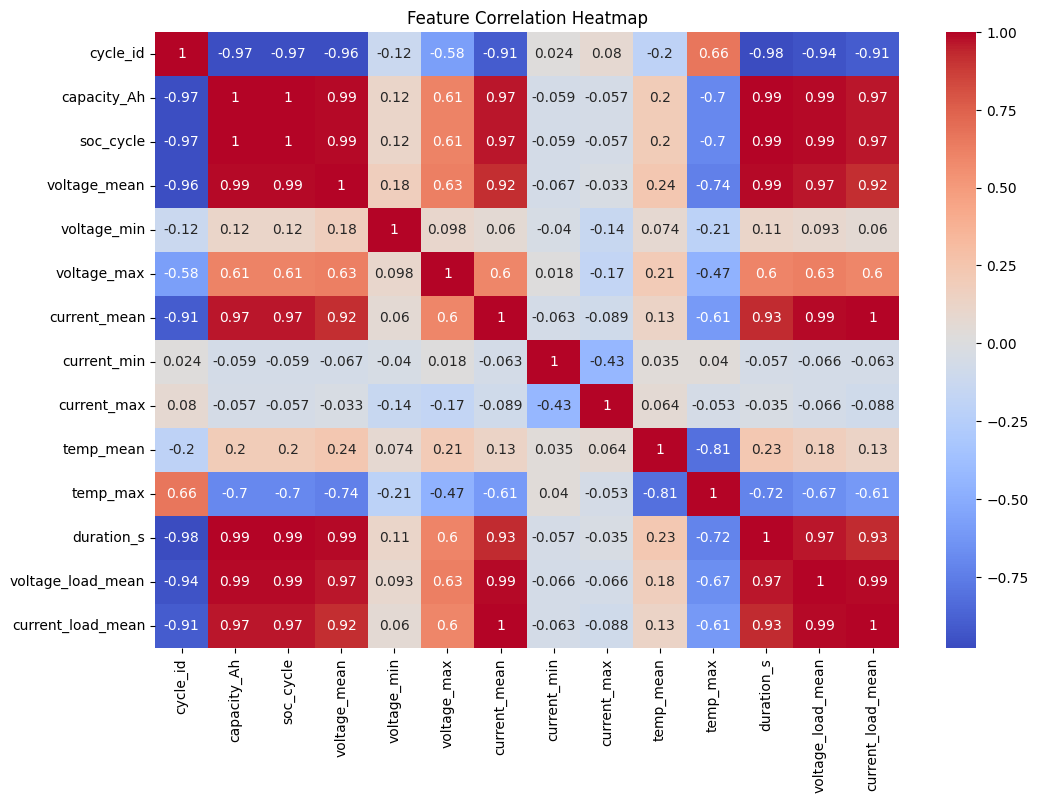

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(df_summary.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


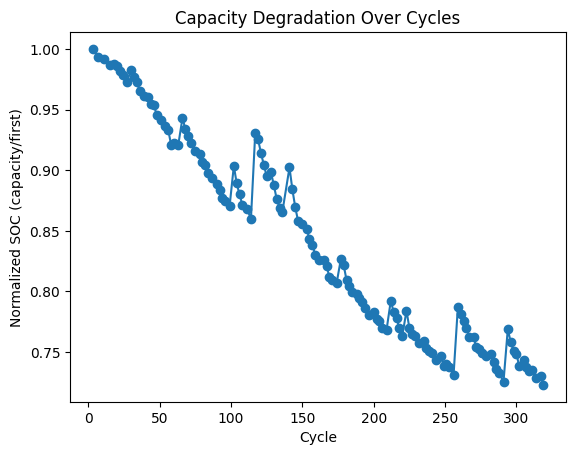

In [211]:
plt.plot(df_summary["cycle_id"], df_summary["soc_cycle"], marker='o')
plt.xlabel("Cycle")
plt.ylabel("Normalized SOC (capacity/first)")
plt.title("Capacity Degradation Over Cycles")
plt.show()


In [212]:
import numpy as np

def time_to_threshold(time_s, voltage_V, v_thr):
    """Discharge sırasında V, eşik altına ilk kez indiği anda geçen süre (s). 
       Eşige hiç inemediyse np.nan döner."""
    idx = np.where(voltage_V <= v_thr)[0]
    if idx.size == 0:
        return np.nan
    return float(time_s[idx[0]] - time_s[0])


In [213]:
import pandas as pd
import numpy as np

# df_timeseries zaten mevcut varsayıyoruz
rows = []
vthr = 2.7  # istersen ayarla

for _, r in df_timeseries.iterrows():
    tm = r["time_s"]
    V  = r["voltage_V"]
    T  = r["temperature_C"]
    I  = r["current_A"]
    Vload = r["voltage_load_V"]
    Iload = r["current_load_A"]

    # --- T tepesine ulaşma süresi
    if len(T) > 0:
        i_tmax = int(np.nanargmax(T))
        t_to_Tmax = float(tm[i_tmax] - tm[0])
        T_max = float(T[i_tmax])
    else:
        t_to_Tmax = np.nan
        T_max = np.nan

    # --- gerilim eşik süreleri (discharge’ta V düşüyor)
    thr_times = {}
    
    thr_times[f"t_to_{str(vthr)}V"] = time_to_threshold(tm, V, vthr)


    # --- ısıl integral (ortam T ~ ilk 5 sn ortalaması varsayımı)
    Tamb = float(np.nanmean(T[: len(T)])) if len(T) > 0 else np.nan
    pos_over = np.clip(T - Tamb, 0, None)
    thermal_integral = float(np.trapz(pos_over, tm)) if len(pos_over)>1 else np.nan

    # --- measured vs load farkları (ort/standart sapma)
    V_diff_mean = float(np.nanmean(V - Vload)) if len(V)==len(Vload) else np.nan
    I_diff_mean = float(np.nanmean(I - Iload)) if len(I)==len(Iload) else np.nan

    rows.append({
        "cycle_id": r["cycle_id"],
        "datetime": r["datetime"],
        "capacity_Ah": r["capacity_Ah"],
        "soc_cycle": r["soc_cycle"],  # capacity/first_cap

        # makale-çekirdek:
        **thr_times,
        "t_to_Tmax": t_to_Tmax,
        "T_max": -T_max,

        # öneri-ek:
        "thermal_integral": thermal_integral,
        "Vmeas_minus_Vload_mean": V_diff_mean,
        "Imeas_minus_Iload_mean": I_diff_mean,

        # baz istatistikler (işine yarar)
        "voltage_mean": float(np.nanmean(V)),
        "current_mean": -float(np.nanmean(I)),
        "temp_mean": -float(np.nanmean(T)),
        "duration_s": float(tm[-1]-tm[0]) if len(tm)>1 else np.nan,
    })

df_summary_ext = pd.DataFrame(rows).sort_values("datetime").reset_index(drop=True)
df_summary_ext.head()


C:\Users\Kenan\AppData\Local\Temp\ipykernel_45324\475358521.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  thermal_integral = float(np.trapz(pos_over, tm)) if len(pos_over)>1 else np.nan


,cycle_id,datetime,capacity_Ah,soc_cycle,t_to_2.7V,t_to_Tmax,T_max,thermal_integral,Vmeas_minus_Vload_mean,Imeas_minus_Iload_mean,voltage_mean,current_mean,temp_mean,duration_s
0,3,2008-07-07 15:15:28,1.855005,1.000000,3338.438,3367.141,-38.101803,4697.180202,0.959858,-3.898528,3.527546,1.954176,-31.773285,3434.891
1,7,2008-07-07 21:53:06,1.843196,0.993634,3318.328,3347.188,-38.149880,4541.925833,0.960813,-3.885463,3.534836,1.947437,-31.924892,3425.485
2,11,2008-07-08 02:56:08,1.839602,0.991697,3312.360,3341.500,-37.526691,4509.942401,0.956180,-3.894887,3.538247,1.952051,-31.316913,3410.375
3,15,2008-07-08 07:58:55,1.830674,0.986884,3296.110,3325.547,-37.062792,4547.211219,0.966394,-3.882907,3.537698,1.946091,-30.821191,3404.719
4,18,2008-07-08 18:57:48,1.832700,0.987976,3298.063,3327.782,-38.211035,4592.621966,0.974179,-3.872482,3.542668,1.941280,-31.953470,3417.641


In [214]:
# sadece sayısal kolonları al
num_cols = df_summary_ext.select_dtypes(include=[np.number]).columns

pearson_corr  = df_summary_ext[num_cols].corr(method="pearson")
spearman_corr = df_summary_ext[num_cols].corr(method="spearman")

pearson_corr.head(), spearman_corr.head()


(             cycle_id  capacity_Ah  soc_cycle  t_to_2.7V  t_to_Tmax     T_max  \
 cycle_id     1.000000    -0.970329  -0.970329  -0.970232  -0.971260 -0.660024   
 capacity_Ah -0.970329     1.000000   1.000000   0.999998   0.999415  0.695210   
 soc_cycle   -0.970329     1.000000   1.000000   0.999998   0.999415  0.695210   
 t_to_2.7V   -0.970232     0.999998   0.999998   1.000000   0.999407  0.695917   
 t_to_Tmax   -0.971260     0.999415   0.999415   0.999407   1.000000  0.689639   
 
              thermal_integral  Vmeas_minus_Vload_mean  Imeas_minus_Iload_mean  \
 cycle_id             0.537630                0.909627                0.906662   
 capacity_Ah         -0.669874               -0.968224               -0.966144   
 soc_cycle           -0.669874               -0.968224               -0.966144   
 t_to_2.7V           -0.670293               -0.968196               -0.966087   
 t_to_Tmax           -0.662084               -0.969082               -0.966752   
 
            

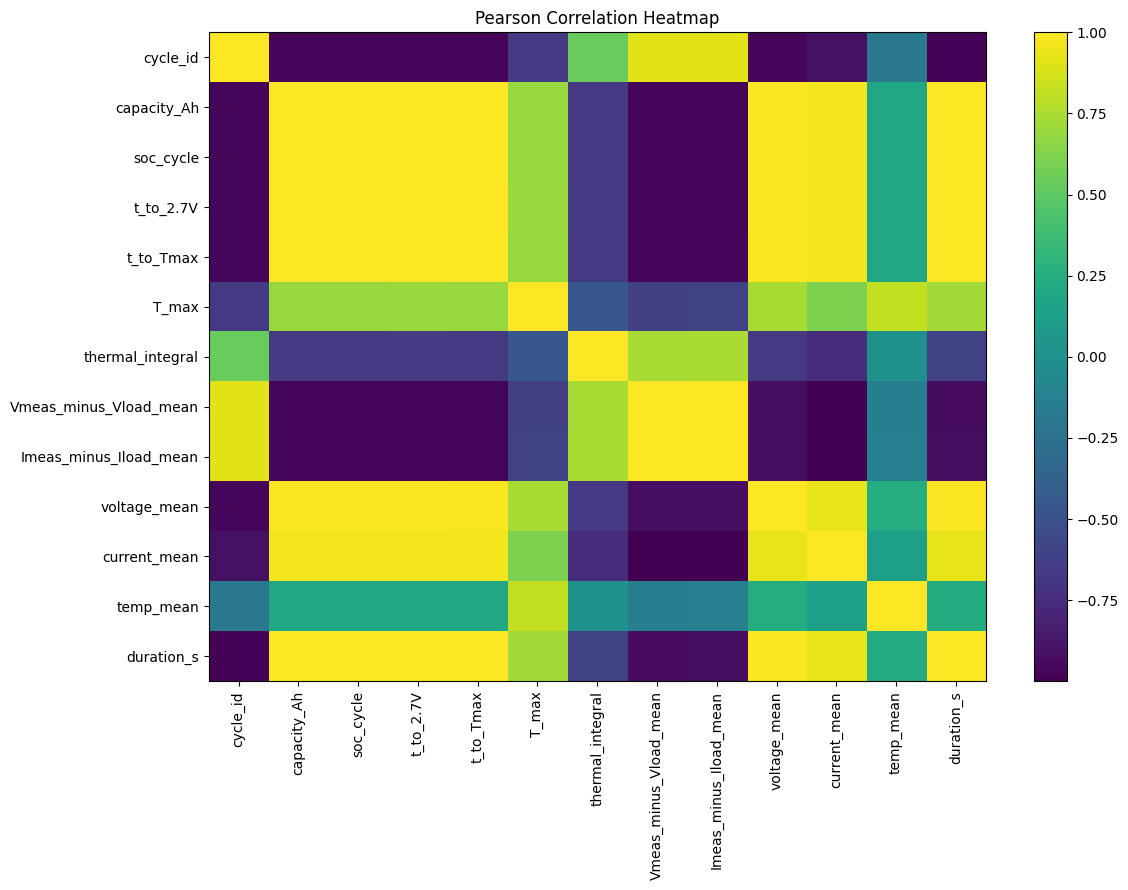

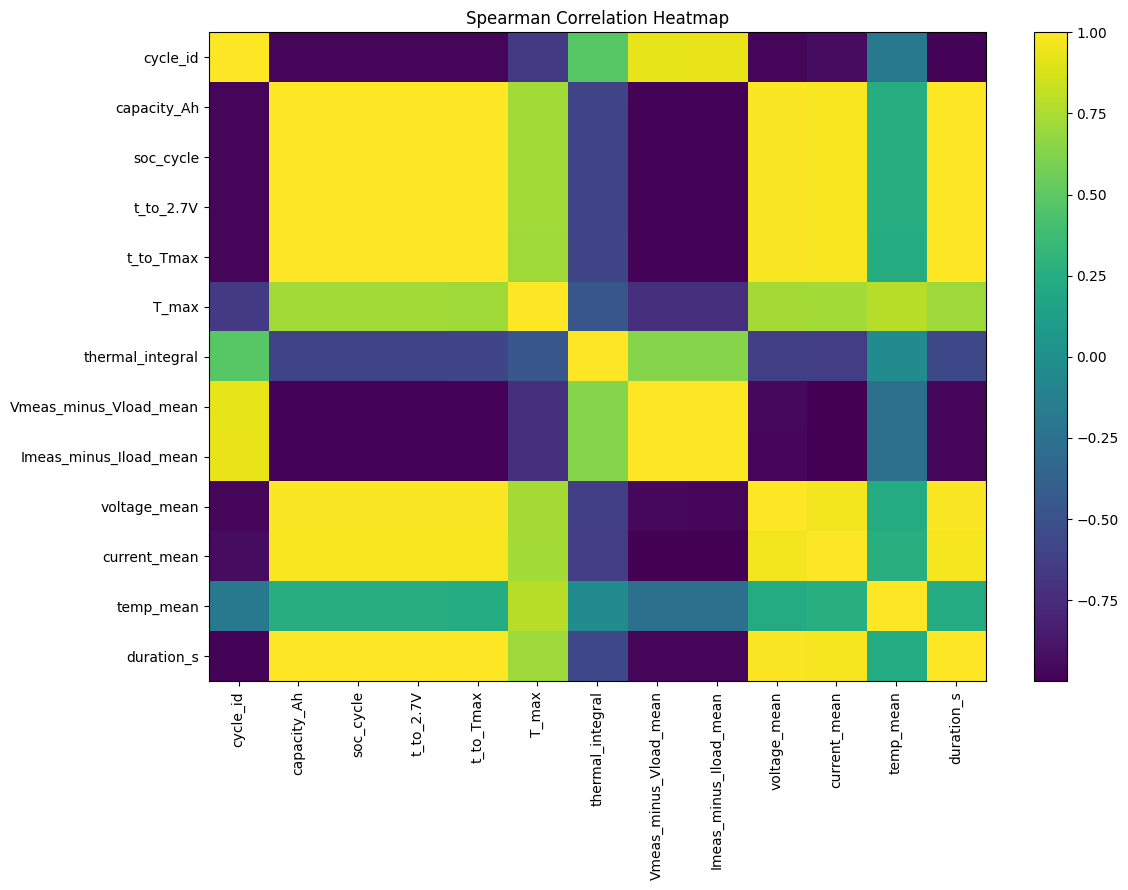

In [215]:
import matplotlib.pyplot as plt

def plot_heatmap(mat, title):
    fig, ax = plt.subplots(figsize=(12, 9))
    cax = ax.imshow(mat, interpolation='nearest', aspect='auto')
    ax.set_title(title)
    ax.set_xticks(range(len(mat.columns)))
    ax.set_yticks(range(len(mat.index)))
    ax.set_xticklabels(mat.columns, rotation=90)
    ax.set_yticklabels(mat.index)
    fig.colorbar(cax)
    plt.tight_layout()
    plt.show()

plot_heatmap(pearson_corr,  "Pearson Correlation Heatmap")
plot_heatmap(spearman_corr, "Spearman Correlation Heatmap")


In [216]:
target_cols = ["soc_cycle", "capacity_Ah"]
feature_cols = [
    "duration_s",
    "t_to_Tmax",
    "T_max",
    "thermal_integral",
    "Vmeas_minus_Vload_mean",
    "Imeas_minus_Iload_mean",
    "voltage_mean", "current_mean", "temp_mean"
]

sub = df_summary_ext[target_cols + feature_cols].copy()

print("Pearson w.r.t. soc_cycle")
print(sub.corr(method="pearson")["soc_cycle"].sort_values(ascending=False))

print("\nSpearman w.r.t. soc_cycle")
print(sub.corr(method="spearman")["soc_cycle"].sort_values(ascending=False))

print("\nPearson w.r.t. capacity_Ah")
print(sub.corr(method="pearson")["capacity_Ah"].sort_values(ascending=False))

print("\nSpearman w.r.t. capacity_Ah")
print(sub.corr(method="spearman")["capacity_Ah"].sort_values(ascending=False))


Pearson w.r.t. soc_cycle
soc_cycle                 1.000000
capacity_Ah               1.000000
t_to_Tmax                 0.999415
duration_s                0.992636
voltage_mean              0.985595
current_mean              0.966038
T_max                     0.695210
temp_mean                 0.200069
thermal_integral         -0.669874
Imeas_minus_Iload_mean   -0.966144
Vmeas_minus_Vload_mean   -0.968224
Name: soc_cycle, dtype: float64

Spearman w.r.t. soc_cycle
soc_cycle                 1.000000
capacity_Ah               1.000000
t_to_Tmax                 0.998863
duration_s                0.997762
voltage_mean              0.988704
current_mean              0.980553
T_max                     0.721168
temp_mean                 0.243821
thermal_integral         -0.589007
Vmeas_minus_Vload_mean   -0.977376
Imeas_minus_Iload_mean   -0.980543
Name: soc_cycle, dtype: float64

Pearson w.r.t. capacity_Ah
capacity_Ah               1.000000
soc_cycle                 1.000000
t_to_Tmax       

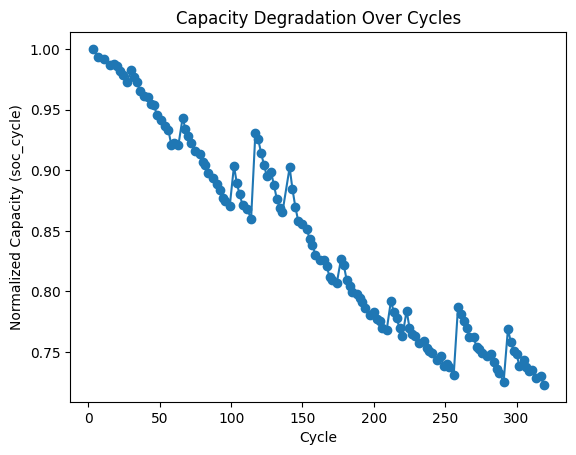

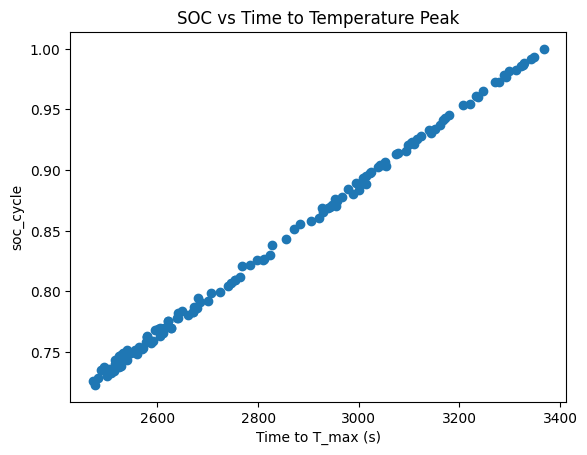

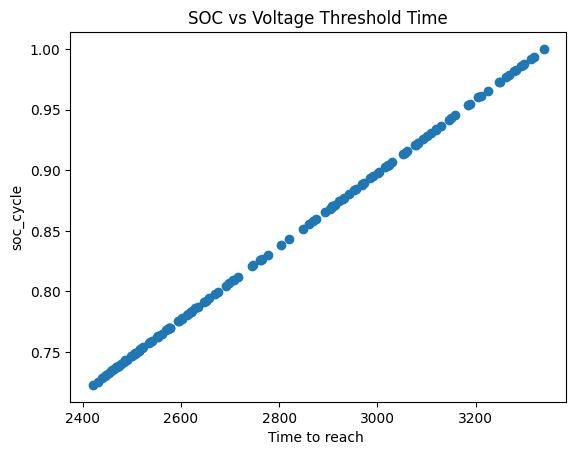

In [217]:
# kapasite / SOC trendi
plt.figure()
plt.plot(df_summary_ext["cycle_id"], df_summary_ext["soc_cycle"], marker='o')
plt.xlabel("Cycle")
plt.ylabel("Normalized Capacity (soc_cycle)")
plt.title("Capacity Degradation Over Cycles")
plt.show()

# T tepe zamanı vs SOC
plt.figure()
plt.scatter(df_summary_ext["t_to_Tmax"], df_summary_ext["soc_cycle"])
plt.xlabel("Time to T_max (s)")
plt.ylabel("soc_cycle")
plt.title("SOC vs Time to Temperature Peak")
plt.show()

# Gerilim eşiği süresi vs SOC
plt.figure()
plt.scatter(df_summary_ext["t_to_2.7V"], df_summary_ext["soc_cycle"])
plt.xlabel("Time to reach ")
plt.ylabel("soc_cycle")
plt.title("SOC vs Voltage Threshold Time")
plt.show()


In [218]:
soc_zero_durations = []

for _, row in df_timeseries.iterrows():
    soc_t = row["soc_cyclecap_t"]
    t = row["time_s"]
    if len(soc_t) > 0:
        # SOC 0'a en yakın noktayı bul
        idx_zero = np.nanargmin(soc_t)
        soc_zero_durations.append(float(t[idx_zero] - t[0]))
    else:
        soc_zero_durations.append(np.nan)

df_summary_ext["soc_zero_duration"] = soc_zero_durations


In [219]:
mean_rates, max_rates = [], []

for _, row in df_timeseries.iterrows():
    soc_t = row["soc_cyclecap_t"]
    t = row["time_s"]
    if len(soc_t) > 1:
        dSOCdt = np.gradient(soc_t, t)
        mean_rates.append(-np.nanmean(dSOCdt))   # ortalama eğim
        max_rates.append(-np.nanmin(dSOCdt))     # en hızlı düşüş (negatif)
    else:
        mean_rates.append(np.nan)
        max_rates.append(np.nan)

df_summary_ext["soc_mean_rate"] = mean_rates
df_summary_ext["soc_max_rate"] = max_rates


In [220]:
seg_features = []

for _, row in df_timeseries.iterrows():
    soc_t = row["soc_cyclecap_t"]
    n = len(soc_t)
    if n < 4:
        seg_features.append((np.nan, np.nan, np.nan, np.nan))
        continue
    # dört eşit parçaya böl
    quarters = [0, n//4, n//2, 3*n//4, n-1]
    deltas = []
    for i in range(4):
        d = soc_t[quarters[i]] - soc_t[quarters[i+1]]
        deltas.append(d)
    seg_features.append(tuple(deltas))

df_summary_ext[["soc_drop_q1","soc_drop_q2","soc_drop_q3","soc_drop_q4"]] = -pd.DataFrame(seg_features)


In [221]:
soc_features = []

for _, row in df_timeseries.iterrows():
    soc_whole = row["soc_whole_t"]
    soc_cyclecap = row["soc_cyclecap_t"]
    t = row["time_s"]

    if len(soc_whole) > 1:
        dSOC_whole_dt = np.gradient(soc_whole, t)
        dSOC_cyclecap_dt = np.gradient(soc_cyclecap, t)

        soc_features.append({
            "cycle_id": row["cycle_id"],
            "soc_whole_mean": np.nanmean(soc_whole),
            "soc_whole_max": np.nanmax(soc_whole),
            "soc_whole_rate_mean": np.nanmean(dSOC_whole_dt),
            "soc_whole_rate_min": np.nanmin(dSOC_whole_dt),

            "soc_cyclecap_mean": np.nanmean(soc_cyclecap),
            "soc_cyclecap_rate_mean": np.nanmean(dSOC_cyclecap_dt),
            "soc_cyclecap_rate_min": np.nanmin(dSOC_cyclecap_dt),
        })
    else:
        soc_features.append({
            "cycle_id": row["cycle_id"],
            "soc_whole_mean": np.nan,
            "soc_whole_max": np.nan,
            "soc_whole_rate_mean": np.nan,
            "soc_whole_rate_min": np.nan,

            "soc_cyclecap_mean": np.nan,
            "soc_cyclecap_rate_mean": np.nan,
            "soc_cyclecap_rate_min": np.nan,
        })

df_soc_feats = pd.DataFrame(soc_features)

# Mevcut özet tabloya ekle
df_summary_ext = df_summary_ext.merge(df_soc_feats, on="cycle_id")
df_timeseries.to_pickle("dataset_timeseries.pkl")


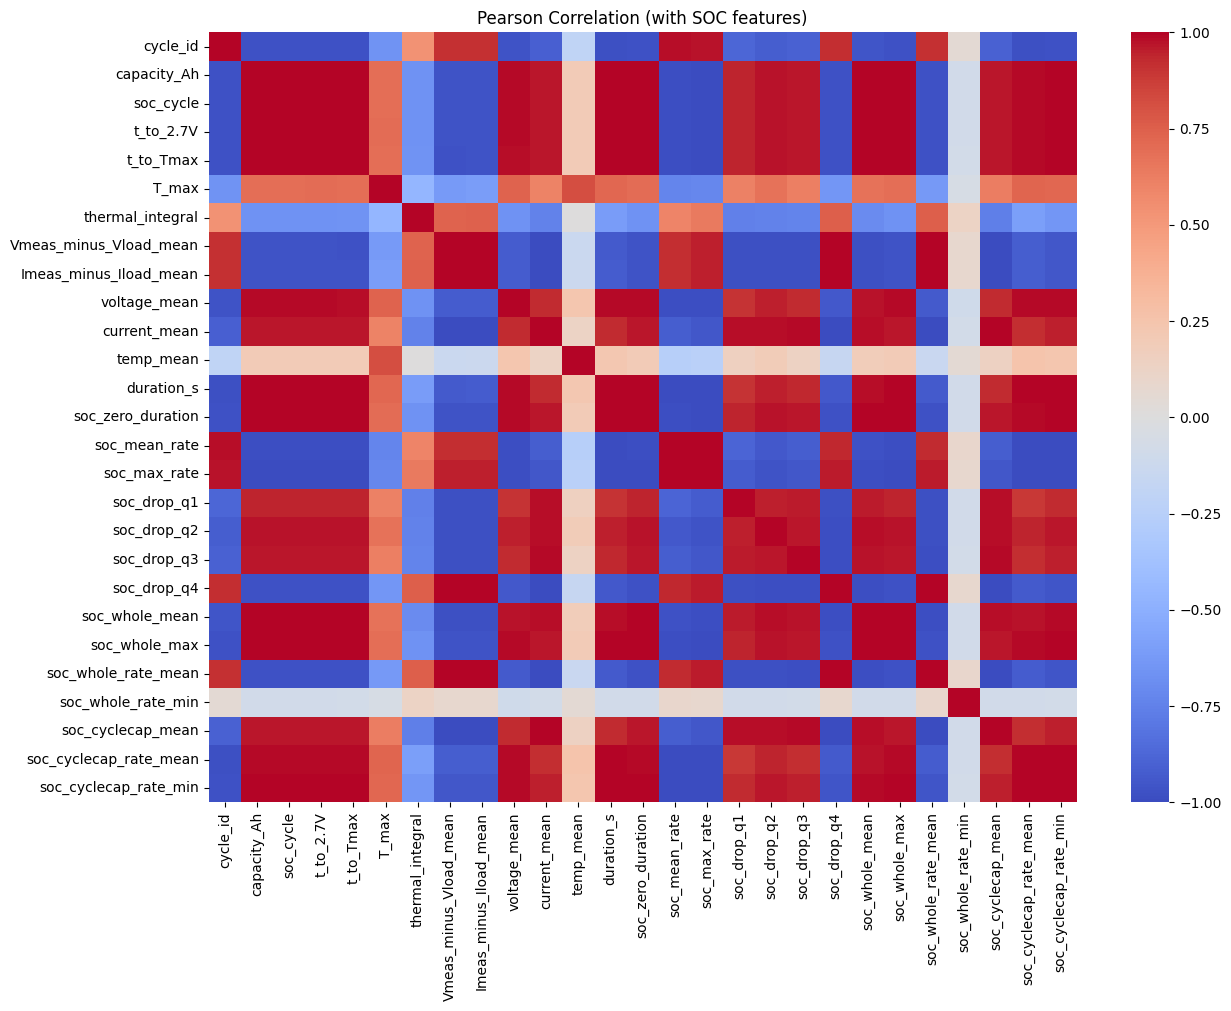

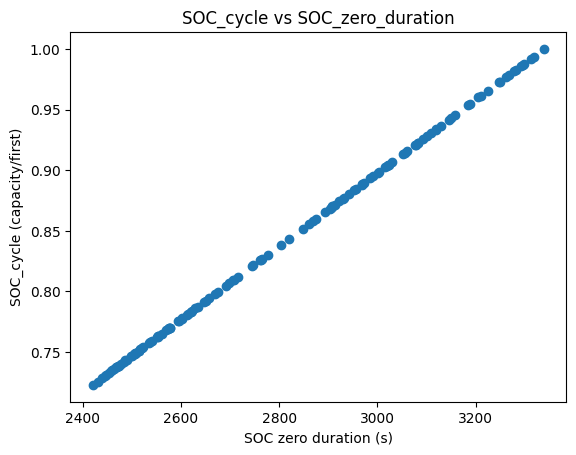

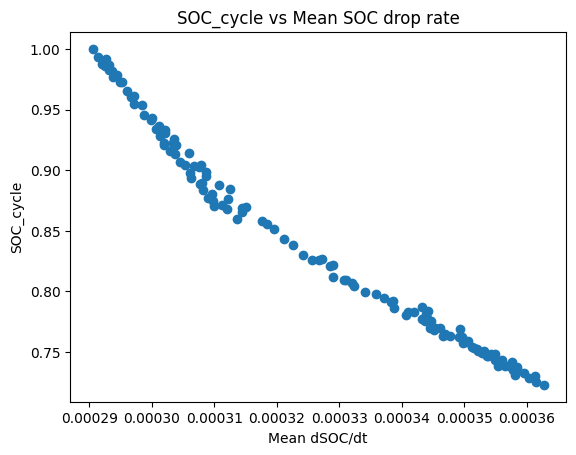

Index(['cycle_id', 'datetime', 'capacity_Ah', 'soc_cycle', 't_to_2.7V',
       't_to_Tmax', 'T_max', 'thermal_integral', 'Vmeas_minus_Vload_mean',
       'Imeas_minus_Iload_mean', 'voltage_mean', 'current_mean', 'temp_mean',
       'duration_s', 'soc_zero_duration', 'soc_mean_rate', 'soc_max_rate',
       'soc_drop_q1', 'soc_drop_q2', 'soc_drop_q3', 'soc_drop_q4',
       'soc_whole_mean', 'soc_whole_max', 'soc_whole_rate_mean',
       'soc_whole_rate_min', 'soc_cyclecap_mean', 'soc_cyclecap_rate_mean',
       'soc_cyclecap_rate_min'],
      dtype='object')


In [222]:
import seaborn as sns
import matplotlib.pyplot as plt

# sadece sayısal kolonlar
num_cols = df_summary_ext.select_dtypes(include=[np.number]).columns
corr_mat = df_summary_ext[num_cols].corr(method="pearson")
corr_mat_spearman = df_summary_ext[num_cols].corr(method="spearman")

plt.figure(figsize=(14,10))
sns.heatmap(corr_mat, annot=False, cmap="coolwarm", center=0)
plt.title("Pearson Correlation (with SOC features)")
plt.show()

# Örnek scatter: SOC_cycle ile SOC sıfıra inme süresi
plt.figure()
plt.scatter(df_summary_ext["soc_zero_duration"], df_summary_ext["soc_cycle"])
plt.xlabel("SOC zero duration (s)")
plt.ylabel("SOC_cycle (capacity/first)")
plt.title("SOC_cycle vs SOC_zero_duration")
plt.show()

# Örnek scatter: SOC_cycle ile SOC ortalama düşüş hızı
plt.figure()
plt.scatter(df_summary_ext["soc_mean_rate"], df_summary_ext["soc_cycle"])
plt.xlabel("Mean dSOC/dt")
plt.ylabel("SOC_cycle")
plt.title("SOC_cycle vs Mean SOC drop rate")
plt.show()
df_summary_ext.to_csv("dataset_summary.csv", index=False)
df_summary_ext.to_pickle("dataset_processed.pkl")
print(df_summary_ext.columns)

In [282]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db_name = "battery_db"  # senin veritabanı ismin
client.drop_database(db_name)

print(f"{db_name} veritabanı silindi.")


battery_db veritabanı silindi.
